# Activation Skewness

### Load data

In [1]:
import numpy as np

fast_model_fast_data = np.load("nighttime_ai_fast_synth_model_fast_synth_data_activations.npy")
fast_model_slow_data = np.load("nighttime_ai_fast_synth_model_slow_data_activations.npy")
slow_model_fast_data = np.load("nighttime_ai_slow_model_fast_synth_data_activations.npy")
slow_model_slow_data = np.load("nighttime_ai_slow_model_slow_data_activations.npy")

[d.shape for d in (fast_model_fast_data, fast_model_slow_data, slow_model_fast_data, slow_model_slow_data)]


[(10150, 256), (10150, 256), (10150, 256), (10150, 256)]

### Basic statistics for activations.

In [2]:

neuron_activations = dict(
    fast_model_IND_data = np.mean(fast_model_fast_data, axis=0),
    fast_model_OOD_data = np.mean(fast_model_slow_data, axis=0),
    slow_model_IND_data = np.mean(slow_model_slow_data, axis=0),
    slow_model_OOD_data = np.mean(slow_model_fast_data, axis=0),
)

for name, data in neuron_activations.items():
    print(f'{name} mean:{data.mean():.4f}, standard deviation of neuron means: {np.std(data):.4f}')

fast_model_IND_data mean:0.2800, standard deviation of neuron means: 0.0985
fast_model_OOD_data mean:0.2646, standard deviation of neuron means: 0.1609
slow_model_IND_data mean:0.3101, standard deviation of neuron means: 0.1425
slow_model_OOD_data mean:0.3320, standard deviation of neuron means: 0.3750


In [3]:
neuron_activations = dict(
    fast_model_IND_data=fast_model_fast_data.std(axis=0),
    fast_model_OOD_data=fast_model_slow_data.std(axis=0),
    slow_model_IND_data=slow_model_slow_data.std(axis=0),
    slow_model_OOD_data=slow_model_fast_data.std(axis=0),
)

for name, data in neuron_activations.items():
    print(f'{name} mean of neuron standard deviations: {data.mean():.4f}')


fast_model_IND_data mean of neuron standard deviations: 0.3716
fast_model_OOD_data mean of neuron standard deviations: 0.3271
slow_model_IND_data mean of neuron standard deviations: 0.3955
slow_model_OOD_data mean of neuron standard deviations: 0.3284


In [4]:

from scipy.stats import skew

neuron_activations = dict(
    fast_model_IND_data = fast_model_fast_data,
    fast_model_OOD_data = fast_model_slow_data,
    slow_model_IND_data = slow_model_slow_data,
    slow_model_OOD_data = slow_model_fast_data
)

for name, data in neuron_activations.items():
    print(f'{name} mean of frame skewness: {skew(data, axis=1).mean():.4f}')

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


fast_model_IND_data mean of frame skewness: 1.5105
fast_model_OOD_data mean of frame skewness: 1.4652
slow_model_IND_data mean of frame skewness: 1.5685
slow_model_OOD_data mean of frame skewness: 1.8136


In [5]:
for name, data in neuron_activations.items():
    print(f'{name} standard deviation of frame skewness: {skew(data, axis=1).std():.4f}')

fast_model_IND_data standard deviation of frame skewness: 0.5198
fast_model_OOD_data standard deviation of frame skewness: 0.4598
slow_model_IND_data standard deviation of frame skewness: 0.3402
slow_model_OOD_data standard deviation of frame skewness: 0.2406


### Frame skewness AUROC

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


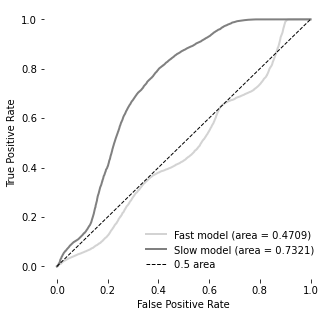

In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_curve(ax, data, title_part, color):
    y_true = data[:, 0]
    y_score = data[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(
        fpr,
        tpr,
        color=color,
        lw=2,
        label=f"{title_part} (area = %0.4f)" % roc_auc,
    )

fig, ax = plt.subplots(figsize=(5, 5))

skewness_test_fast = skew(fast_model_fast_data, axis=1)
skewness_ood_fast = skew(fast_model_slow_data, axis=1)
skewness_test_slow = skew(slow_model_slow_data, axis=1)
skewness_ood_slow = skew(slow_model_fast_data, axis=1)

fast_IND_skewness = np.vstack([np.zeros(len(skewness_test_fast)), skewness_test_fast]).T
fast_OOD_skewness = np.vstack([np.ones(len(skewness_ood_fast)), skewness_ood_fast]).T
slow_IND_skewness = np.vstack([np.zeros(len(skewness_test_slow)), skewness_test_slow]).T
slow_OOD_skewness = np.vstack([np.ones(len(skewness_ood_slow)), skewness_ood_slow]).T


plot_curve(ax, np.concatenate((fast_IND_skewness, fast_OOD_skewness,)), 'Fast model', 'lightgrey')
plot_curve(ax, np.concatenate((slow_IND_skewness, slow_OOD_skewness,)), 'Slow model', 'grey')
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")

plt.show()
